<a href="https://colab.research.google.com/github/TeamHub2/Deep-Learning/blob/main/Face_mask_Detection_using_mobileNet_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
DIRECTORY = r"/content/drive/MyDrive/Face_mask_Detection/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [ ]:
# grab the list of images in our dataset directory, then initialize
print("[INFO] loading images...")
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# convert text to Binary
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# Create head and the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Call head and the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them
for layer in baseModel.layers:
	layer.trainable = False


In [ ]:
# compile our model 17
print("Compilation of the MODEL is going on...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


Compilation of the MODEL is going on...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# train the head of the network
print("Training Head Started...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	steps_per_epoch=len(trainX) // BATCH_SIZE,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BATCH_SIZE,
	epochs=EPOCHS)


Training Head Started...
Epoch 1/20
95/95 [==============================] - 53s 435ms/step - loss: 0.3892 - accuracy: 0.8594 - val_loss: 0.1472 - val_accuracy: 0.9831
Epoch 2/20
95/95 [==============================] - 40s 417ms/step - loss: 0.1367 - accuracy: 0.9648 - val_loss: 0.0767 - val_accuracy: 0.9909
Epoch 3/20
95/95 [==============================] - 39s 415ms/step - loss: 0.0945 - accuracy: 0.9740 - val_loss: 0.0580 - val_accuracy: 0.9857
Epoch 4/20
95/95 [==============================] - 39s 415ms/step - loss: 0.0714 - accuracy: 0.9809 - val_loss: 0.0465 - val_accuracy: 0.9883
Epoch 5/20
95/95 [==============================] - 40s 419ms/step - loss: 0.0629 - accuracy: 0.9822 - val_loss: 0.0402 - val_accuracy: 0.9896
Epoch 6/20
95/95 [==============================] - 40s 418ms/step - loss: 0.0527 - accuracy: 0.9842 - val_loss: 0.0419 - val_accuracy: 0.9857
Epoch 7/20
95/95 [==============================] - 40s 419ms/step - loss: 0.0536 - accuracy: 0.9835 - val_loss: 0.03

In [ ]:
# make predictions on the testing set
print("Network evaluation...")
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)

predIdxs = np.argmax(predIdxs, axis=1)


Network evaluation...


In [ ]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       384
without_mask       1.00      0.98      0.99       384

    accuracy                           0.99       768
   macro avg       0.99      0.99      0.99       768
weighted avg       0.99      0.99      0.99       768



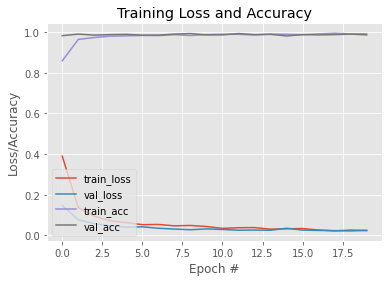

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
# serialize the model to disk
print("saving mask model...")
model.save("mask_detector.model", save_format="h5")

saving mask model...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:

# ডাউনলোড করি h5 হিসেবে
from google.colab import files
files.download('mask_detector.model')

print('mask_dectector.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

mask_dectector.tflite` has been downloaded
